In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
y = train_data.SalePrice.values
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# 1) Data Observations & Visualizations

**Distribution of Sale Price**

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


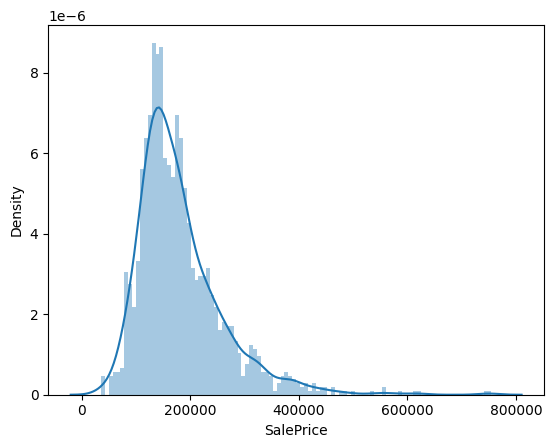

In [4]:
print(train_data['SalePrice'].describe())
sns.distplot(train_data['SalePrice'], bins=100);

Some observations
- skewed positively
- has one peak
- deviate from normal distribution

**Distribution of Numerical Features**

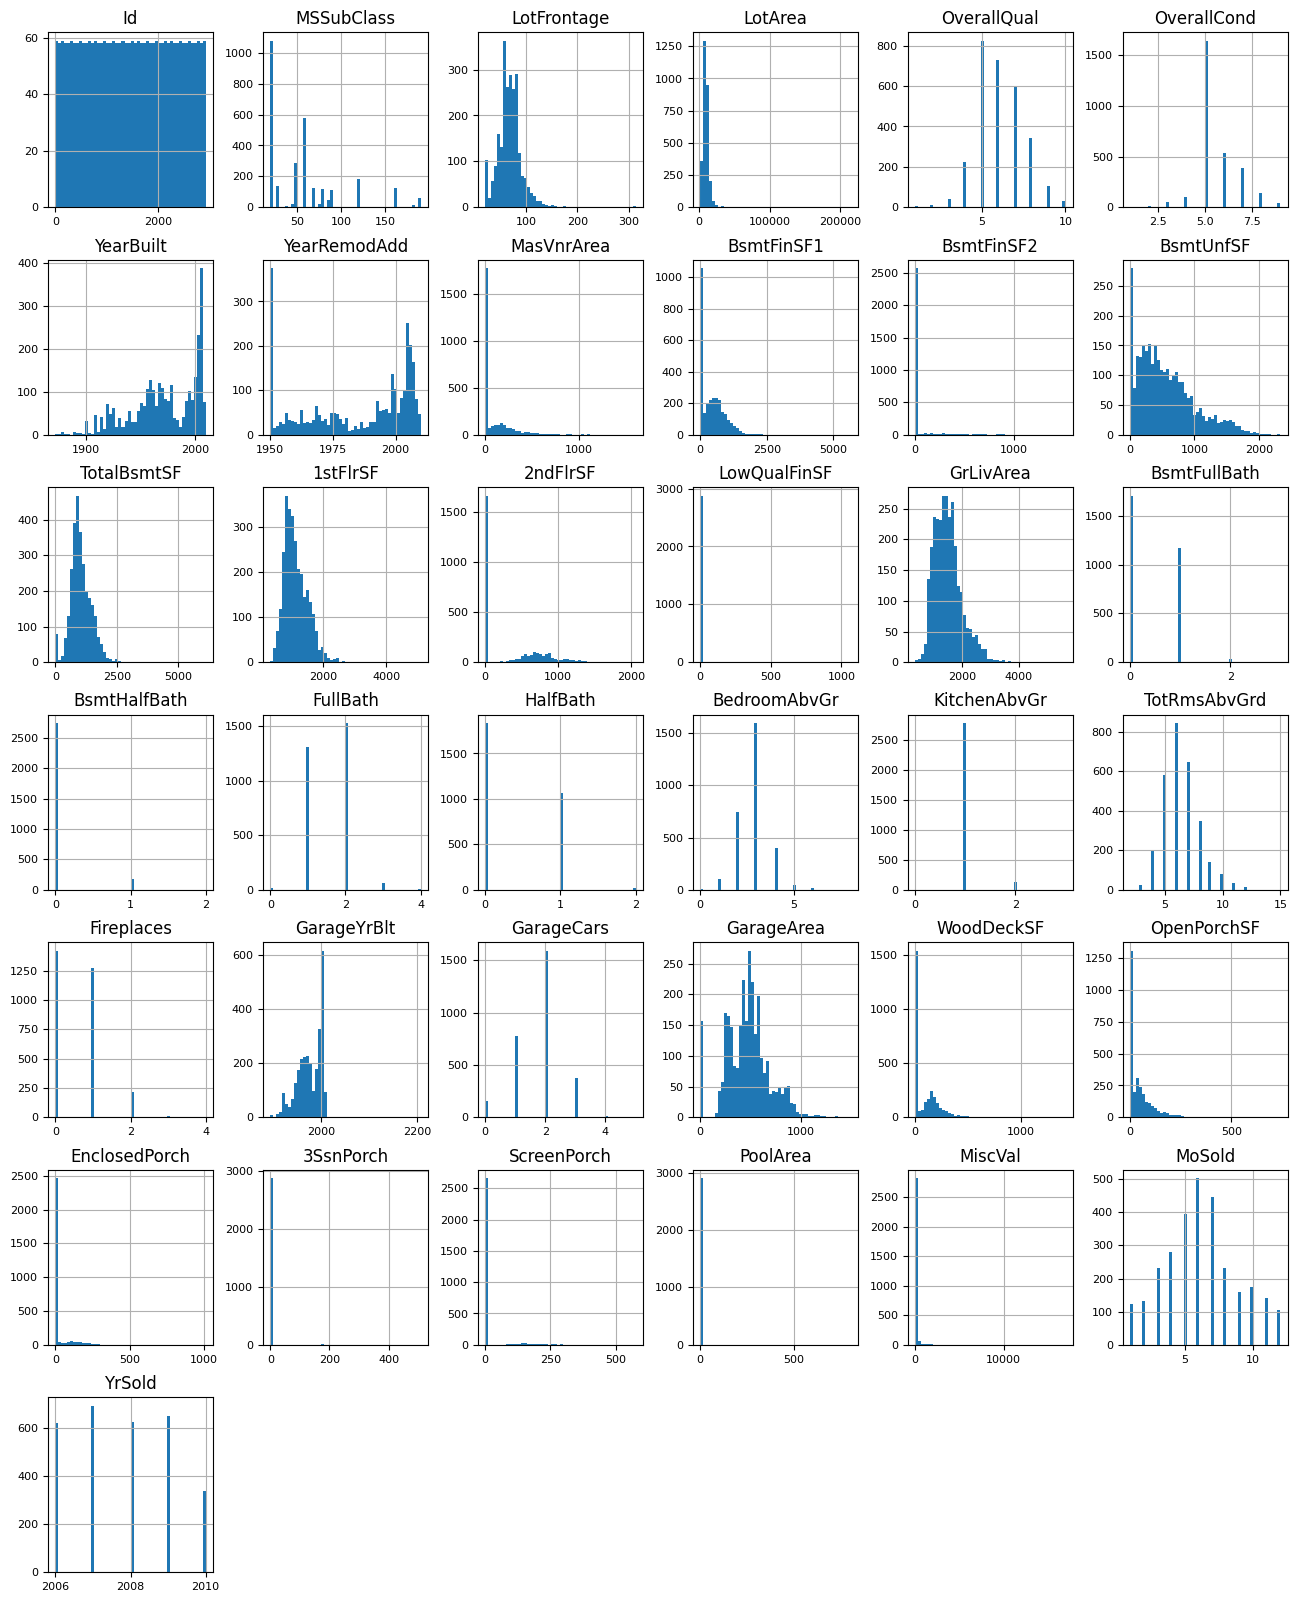

In [5]:
num_col = all_data.select_dtypes(include = ['float64', 'int64'])
hist = num_col.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

Pool area and variables related to porch has very low variability. Some variables that possibly have the biggest influence on the SalePrice: any variables related to the living space area  (e.g. GrLiveArea, 1stFlrSF), quality (e.g. OverallQual, YearBuilt), neighborhood.

<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

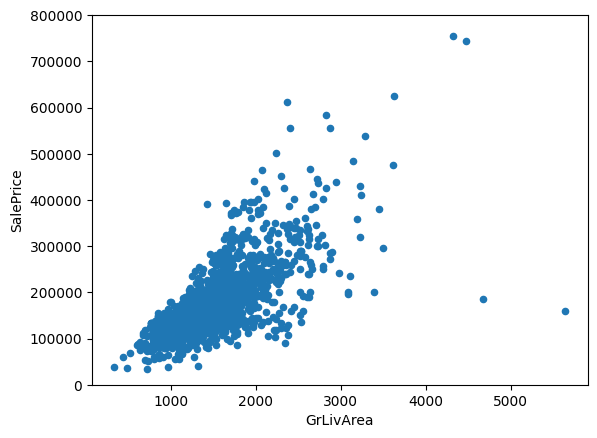

In [6]:
# scatter plot of GrLivArea vs. SalePrice
data = pd.concat([train_data['SalePrice'], train_data['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

(-0.5, 9.5, 0.0, 800000.0)

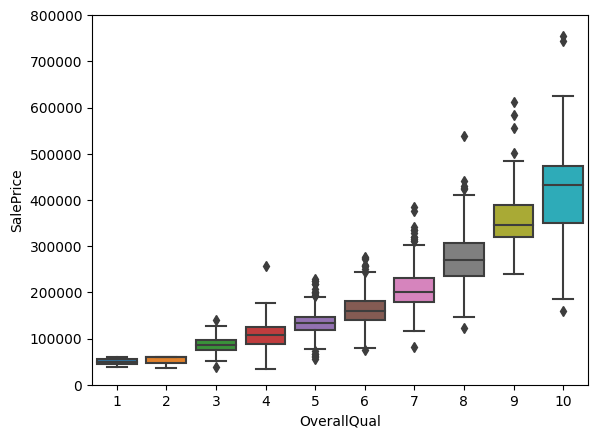

In [7]:
# boxplot of OverallQual vs. SalePrice
data = pd.concat([train_data['SalePrice'], train_data['OverallQual']], axis=1)
fig = sns.boxplot(x='OverallQual', y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

<AxesSubplot: xlabel='YearBuilt', ylabel='SalePrice'>

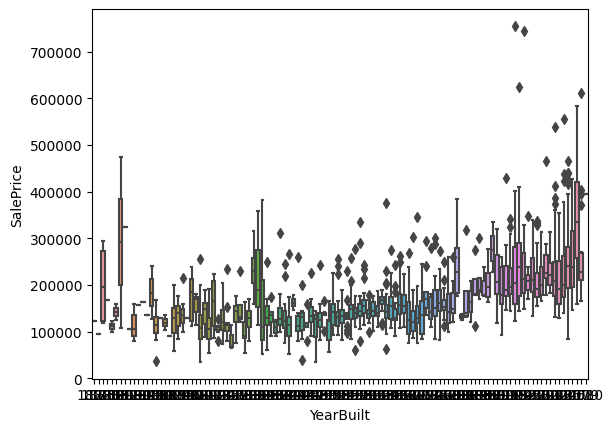

In [8]:
#boxplot of YearBuilt vs. SalePrice
data = pd.concat([train_data['SalePrice'], train_data['YearBuilt']], axis=1)
sns.boxplot(x='YearBuilt', y='SalePrice', data=data)

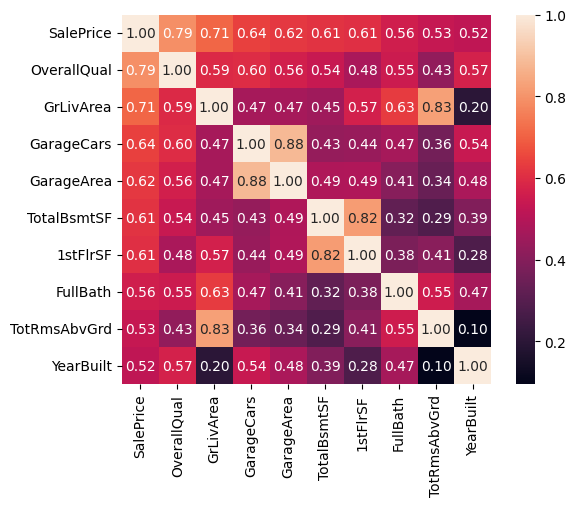

In [9]:
# correlation matrix
k = 10
corr = train_data.corr()
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- GarageCars and GarageArea are strongly correlated. 
- TotalBsmtSF and 1stFlrSF are also strongly correlated.
- TotRmsAbvGrd and GrLivArea are also strongly correlated. 
- We can see strong positive correlation between GrLiveArea, OverallQual and SalePrice

# 2) Data Manipulation

**Missing Data**

In [10]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471


**Garage related variables**: most missing entries have GarageArea = 0.

In [11]:
garage_var_cat = ['GarageCond', 'GarageFinish', 'GarageType', 'GarageQual','GarageArea']
garage_var_int = ['GarageCars','GarageYrBlt']

# one missing garage area and one that's missing other values with a nonzero garage area
null_garage = all_data[all_data['GarageCond'].isnull() & all_data['GarageArea']!=0][garage_var_cat]
null_area = all_data[all_data['GarageArea'].isnull()][garage_var_cat]
null_garage.append(null_area)

,GarageCond,GarageFinish,GarageType,GarageQual,GarageArea
2126,NaN,NaN,Detchd,NaN,360.0
2576,NaN,NaN,Detchd,NaN,NaN


For the two entries with an unknown garage area and non-zero garage area, fill the rest of the variables with its mode. All the other entries with any missing garage related variables do not have a garage (GarageArea = 0). Therefore, we can fill the NaN values with 'NA' or 0.

In [12]:
all_data.groupby('GarageQual')['Id'].describe()

,count,mean,std,min,25%,50%,75%,max
GarageQual,,,,,,,,
Ex,3.0,405.333333,310.799507,186.0,227.50,269.0,515.00,761.0
Fa,124.0,1701.096774,876.904009,9.0,1032.00,1829.5,2453.50,2905.0
Gd,24.0,1403.666667,827.306087,10.0,777.50,1370.5,2187.50,2819.0
Po,5.0,1044.400000,914.945791,247.0,399.00,515.0,1842.00,2219.0
TA,2604.0,1451.451613,837.101524,1.0,730.75,1447.5,2179.25,2919.0


In [13]:
for i in [2576, 2126]:
    all_data.at[i,'GarageCond'] = 'TA'
    all_data.at[i,'GarageFinish'] = 'Unf'
    all_data.at[i,'GarageQual'] = 'TA'
    
all_data['GarageArea'] = all_data['GarageArea'].transform(lambda x: x.fillna(x.median()))

for col in garage_var_cat:
    all_data[col]=all_data[col].fillna('NA') 

for col in garage_var_int:
    all_data[col]=all_data[col].fillna(0) 

**Basement related variables**: if the total area = 0, then we can fill the categorical variables with 'NA'.

In [14]:
bsmt_var = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtHalfBath','BsmtFullBath','BsmtUnfSF','TotalBsmtSF']

# if TotalBsmtSF=0, fill the categorical basement variables with NA
bsmt_var_cat = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
for col in bsmt_var_cat:
    all_data.loc[all_data['TotalBsmtSF']==0, col] = 'NA'

# missing basement bathroom info has no basement.
bsmt_var_int = ['BsmtHalfBath','BsmtFullBath']
for col in bsmt_var_int:
    all_data[col]=all_data[col].fillna(0)

In [15]:
null_qual = all_data[all_data['BsmtQual'].isnull()][bsmt_var]
null_cond = all_data[all_data['BsmtCond'].isnull()][bsmt_var]
null_exp = all_data[all_data['BsmtExposure'].isnull()][bsmt_var]
null_fin1 = all_data[all_data['BsmtFinType1'].isnull()][bsmt_var]
null_fin2 = all_data[all_data['BsmtFinType2'].isnull()][bsmt_var]
null_qual.append(null_cond).append(null_exp).append(null_fin1).append(null_fin2)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtHalfBath,BsmtFullBath,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2217,NaN,Fa,No,Unf,Unf,0.0,0.0,0.0,0.0,173.0,173.0
2218,NaN,TA,No,Unf,Unf,0.0,0.0,0.0,0.0,356.0,356.0
2040,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1.0,0.0,1426.0
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2185,TA,NaN,No,BLQ,Unf,1033.0,0.0,1.0,0.0,94.0,1127.0
2524,TA,NaN,Av,ALQ,Unf,755.0,0.0,0.0,0.0,240.0,995.0
948,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,936.0,936.0
1487,Gd,TA,NaN,Unf,Unf,0.0,0.0,0.0,0.0,1595.0,1595.0
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


Fill the missing BsmtCond, BsmtQual, and BsmtExposure values with the mode. For BsmtFinType1 and BsmtFinType2, find the mode but exclude Unf or NA from the possibility because the area is a non zero value. 

In [16]:
# Find the mode
all_data.groupby(['BsmtFinType2'])['Id'].count()

BsmtFinType2
ALQ      52
BLQ      68
GLQ      34
LwQ      87
NA       78
Rec     105
Unf    2493
Name: Id, dtype: int64

In [17]:
all_data['BsmtQual']=all_data['BsmtQual'].fillna('TA') 
all_data['BsmtCond']=all_data['BsmtCond'].fillna('TA')
all_data['BsmtExposure']=all_data['BsmtExposure'].fillna('No')
all_data['BsmtFinType1']=all_data['BsmtFinType1'].fillna('GLQ')
all_data['BsmtFinType2']=all_data['BsmtFinType2'].fillna('Rec')

In [18]:
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].transform(lambda x: x.fillna(x.median()))
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].transform(lambda x: x.fillna(x.median()))
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].transform(lambda x: x.fillna(x.median()))
all_data.at[2120,'TotalBsmtSF'] = all_data.iloc[2120]['BsmtFinSF1']+all_data.iloc[2120]['BsmtFinSF2']+all_data.iloc[2120]['BsmtUnfSF']

**MiscFeature, Alley, Fence, FireplaceQu**: null values indicate that there isn't one. Therefore, we will fill the missing values with 'NA'.

In [19]:
cols = ['MiscFeature','Alley', 'Fence','FireplaceQu']
for col in cols:
    all_data[col] = all_data[col].fillna('NA')

**MasVnrType, MasVnrArea**: most houses do not have masonry veneer. 

In [20]:
all_data[all_data['MasVnrType'].isnull()][['Id','MasVnrArea','MasVnrType']]

,Id,MasVnrArea,MasVnrType
234,235,NaN,NaN
529,530,NaN,NaN
650,651,NaN,NaN
936,937,NaN,NaN
973,974,NaN,NaN
977,978,NaN,NaN
1243,1244,NaN,NaN
1278,1279,NaN,NaN
1691,1692,NaN,NaN
1706,1707,NaN,NaN


All the missing MasVnrArea & MasVnrType can be filled with 0 and None as it is the most common value pair. The one that is missing MasVnrType but not the area can be filled with the mode that is not 'None'.

In [21]:
all_data.groupby(all_data['MasVnrType'])['MasVnrArea'].describe()

,count,mean,std,min,25%,50%,75%,max
MasVnrType,,,,,,,,
BrkCmn,25.0,195.480000,160.361082,40.0,67.0,161.0,250.0,621.0
BrkFace,879.0,261.672355,210.335472,0.0,120.0,203.0,340.0,1600.0
None,1742.0,0.707233,14.753979,0.0,0.0,0.0,0.0,344.0
Stone,249.0,239.550201,180.091550,0.0,120.0,200.0,300.0,1224.0


In [22]:
all_data.at[2610,'MasVnrType'] = 'BrkFace'
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

**Functional, Saletype, Utilities, MSZoning, Electrical**: similarly, we fill in the missing values of the following columns with the mode.

In [23]:
all_data.groupby('Utilities')['Id'].describe()

,count,mean,std,min,25%,50%,75%,max
Utilities,,,,,,,,
AllPub,2916.0,1459.853567,843.076291,1.0,729.75,1459.5,2190.25,2919.0
NoSeWa,1.0,945.000000,NaN,945.0,945.00,945.0,945.00,945.0


In [24]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['SaleType'] = all_data['SaleType'].fillna('WD')
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub')
all_data['MSZoning'] = all_data['MSZoning'].fillna('RL')
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

**KitchenQual**: kitchen quality is likely related to the overall quality. 

In [25]:
all_data[all_data['KitchenQual'].isna()]['OverallQual']

1555    5
Name: OverallQual, dtype: int64

(-0.5, 3.5, 0.55, 10.45)

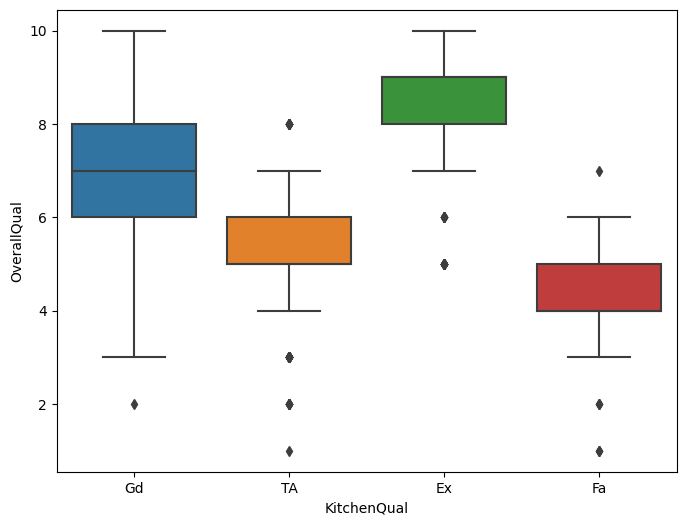

In [26]:
data = pd.concat([all_data['OverallQual'], all_data['KitchenQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=all_data['KitchenQual'], y="OverallQual", data=data)
fig.axis()

In [27]:
all_data['KitchenQual']=all_data['KitchenQual'].fillna('TA')

**LotFrontage**: group by neighborhoods and fill in with the median value

In [28]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**PoolQC, Exterior1st, Exterior2nd**: PoolQC is missing most data and the other two columns seem irrelevant, so we will drop this column.

In [29]:
all_data = all_data.drop(['PoolQC', 'Exterior1st', 'Exterior2nd'], axis=1)

In [30]:
# make sure that there are no missing data
all_data.isnull().sum().max()

0

**Outliers** Bivariate Analysis

<AxesSubplot: xlabel='GrLivArea', ylabel='SalePrice'>

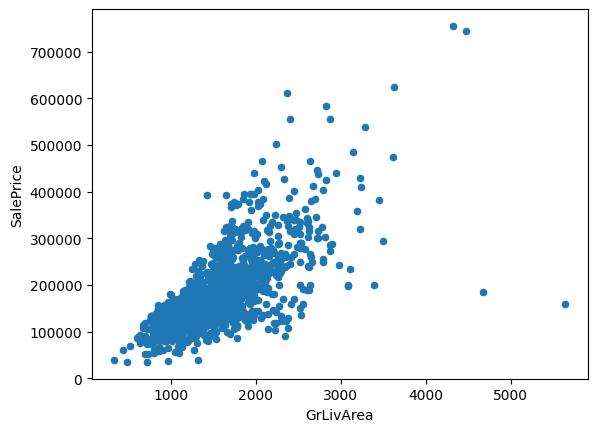

In [31]:
data = pd.concat([train_data['SalePrice'], train_data['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice')

There are two values with high GrLivArea that doesn't follow the trend. They can be deemed as outliers and hence we will delete those points. 

In [32]:
# find the indices of the outliers
train_data.sort_values(by='GrLivArea', ascending=False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


<AxesSubplot: xlabel='1stFlrSF', ylabel='SalePrice'>

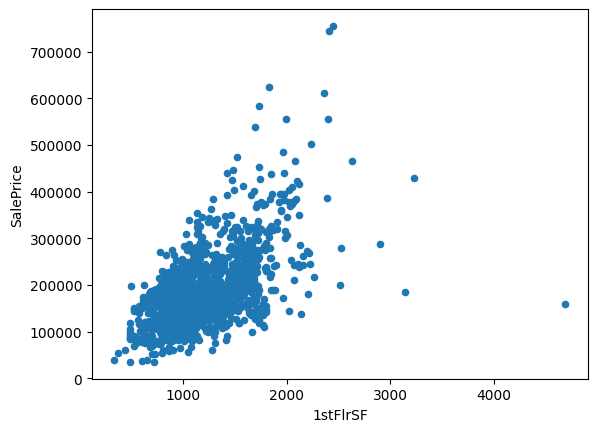

In [33]:
data = pd.concat([train_data['SalePrice'], train_data['1stFlrSF']], axis=1)
data.plot.scatter(x='1stFlrSF', y='SalePrice')

In [34]:
# find the index of the outliers
train_data.sort_values(by='1stFlrSF', ascending=False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


<AxesSubplot: xlabel='TotalBsmtSF', ylabel='SalePrice'>

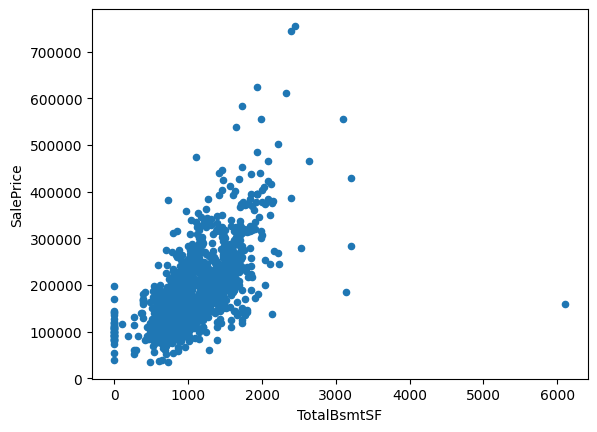

In [35]:
data = pd.concat([train_data['SalePrice'], train_data['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice')

In [36]:
# find the index of the outliers
train_data.sort_values(by='TotalBsmtSF', ascending=False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


<AxesSubplot: xlabel='OverallQual', ylabel='SalePrice'>

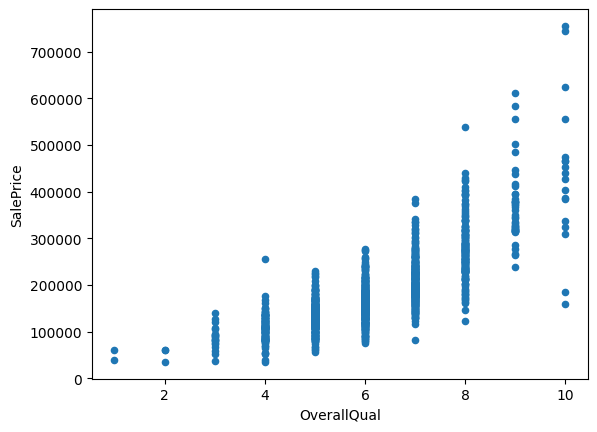

In [37]:
data = pd.concat([train_data['SalePrice'], train_data['OverallQual']], axis=1)
data.plot.scatter(x='OverallQual', y='SalePrice')

In [38]:
# drop the outliers
all_data = all_data.drop(all_data[all_data['Id']==1299].index)
all_data = all_data.drop(all_data[all_data['Id']==524].index)

In [39]:
import numpy as np
y = np.append(y[:1298],y[1299:])
y = np.append(y[:523],y[524:])

In [40]:
ntrain = ntrain-2

**Numerical -> Categorical**

In [41]:
cols = ['MSSubClass','YrSold','MoSold']
for col in cols:
    all_data[col] = all_data[col].astype(str)

**New feature**: total areas

In [42]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = all_data['FullBath'] + 0.5*all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5*all_data['BsmtHalfBath']
all_data['Has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['TotalQual'] = all_data['OverallQual'] + all_data['OverallCond']

**Normality**
Since SalePrice is positively skewed, we will apply log transformation.

In [43]:
# log transformation
y = np.log1p(y)

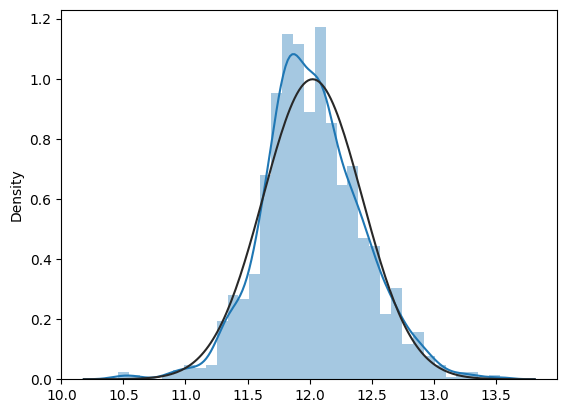

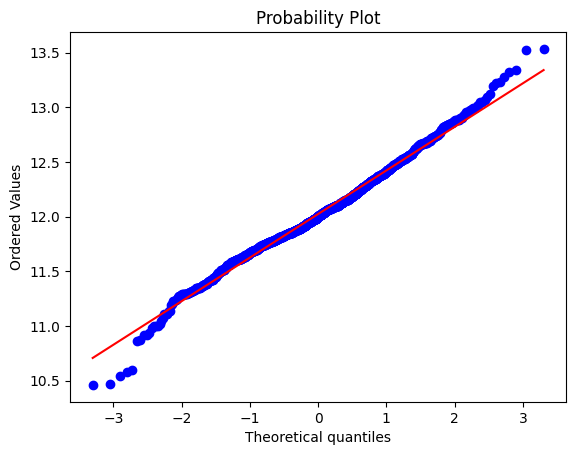

In [44]:
# transformed histogram
from scipy.stats import norm
from scipy import stats
sns.distplot(y, fit=norm);
fig = plt.figure()
res = stats.probplot(y, plot=plt)

**Other skewed features**

In [45]:
# find skewed numerical features
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numeric.append(i)
        
skew_features = all_data[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 26 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

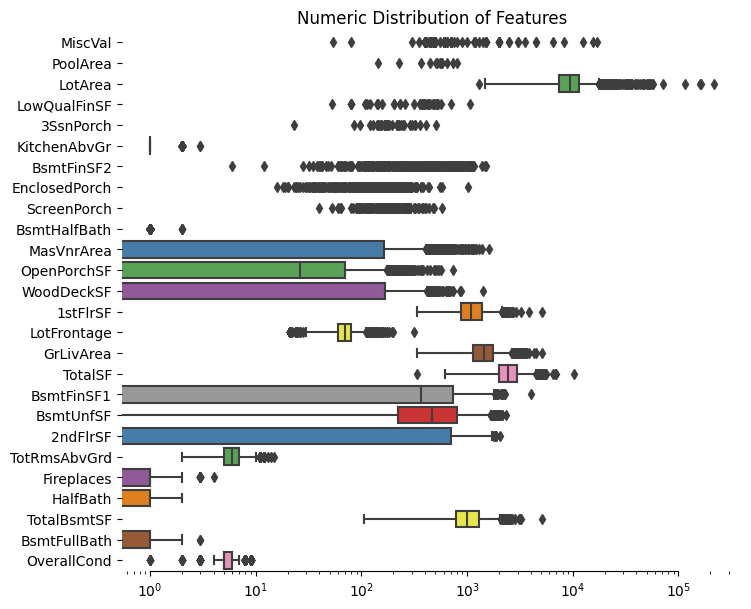

In [46]:
# create box plots for highly skewed columns
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_data[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [47]:
# normalize skewed features
for i in skew_index:
    all_data[i] = boxcox1p(all_data[i], boxcox_normmax(all_data[i] + 1))

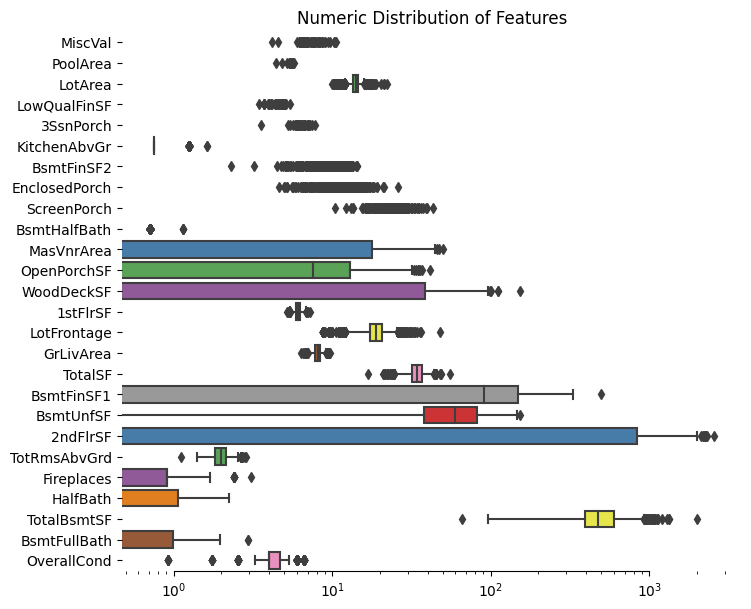

In [48]:
# boxplots of normalized features
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_data[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

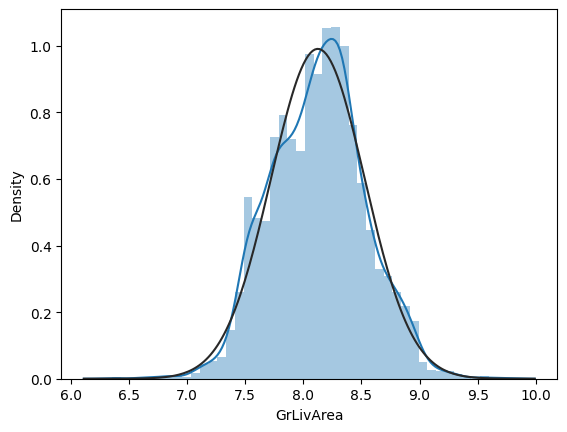

<Figure size 640x480 with 0 Axes>

In [49]:
sns.distplot(all_data['GrLivArea'], fit=norm)
fig = plt.figure()

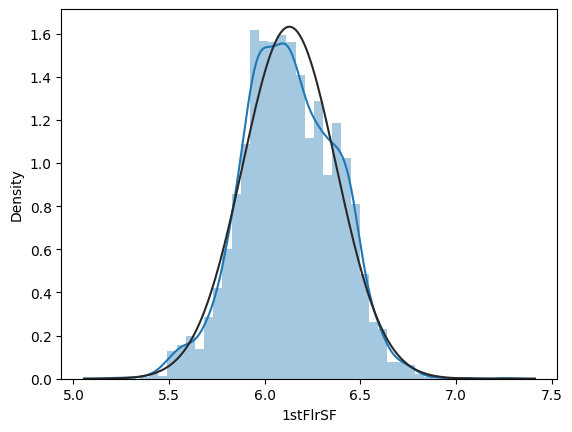

<Figure size 640x480 with 0 Axes>

In [50]:
sns.distplot(all_data['1stFlrSF'], fit=norm)
fig = plt.figure()

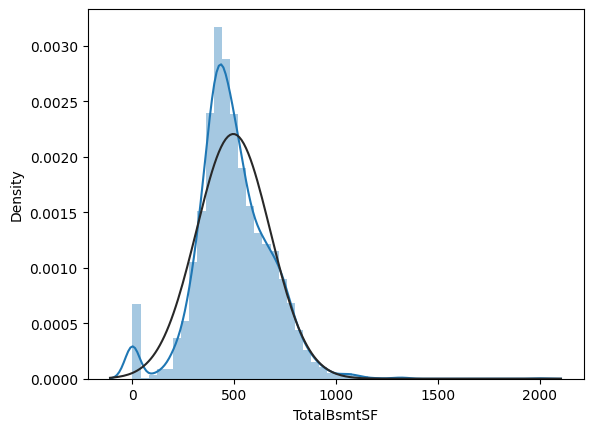

<Figure size 640x480 with 0 Axes>

In [51]:
sns.distplot(all_data['TotalBsmtSF'], fit=norm)
fig = plt.figure()

This column has positive skew and has many observations with value zero. To deal with this, we will create a new variable that indicates if the value is 0 or not (has basement or not), and then apply the log transformation to the non zero values. 

In [52]:
# create a new column 
all_data['HasBsmt'] = pd.Series(len(all_data['TotalBsmtSF']), index=all_data.index)
all_data['HasBsmt'] = 0
all_data.loc[all_data['TotalBsmtSF']>0, 'HasBsmt'] = 1

In [53]:
# log transformation
all_data.loc[all_data['HasBsmt']==1, 'TotalBsmtSF']=np.log(all_data['TotalBsmtSF'])

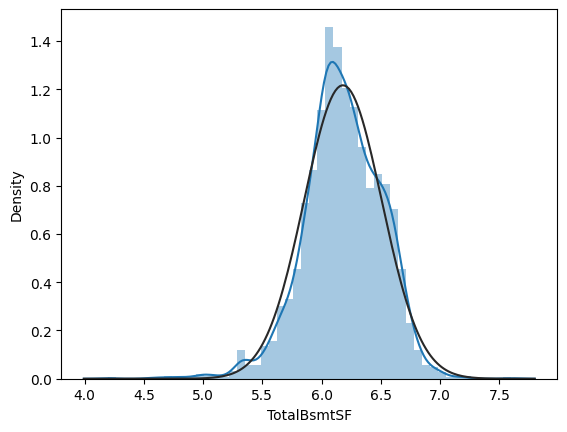

<Figure size 640x480 with 0 Axes>

In [54]:
sns.distplot(all_data[all_data['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm)
fig = plt.figure()

In [55]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 302)

In [56]:
data_id = all_data['Id']
all_data.drop(['Id'], axis=1, inplace=True)
train = all_data[:ntrain]
test = all_data[ntrain:]

In [57]:
train.shape,test.shape, len(y)

((1458, 301), (1459, 301), 1458)

# 3) Modelling

In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from mlxtend.regressor import StackingCVRegressor

pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# validation model
def rmse_val(model):
    scores = -1 * cross_val_score(model, train.values, y,
                              cv=kf,
                              scoring='neg_mean_absolute_error')
    rmse= np.sqrt(scores)
    return(rmse)

def split_dataset(dataset, y, test_ratio=0.3):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices], y[~test_indices], y[test_indices]


In [59]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=1000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=1000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=1000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=500,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [60]:
scores = {}

score = rmse_val(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] baggi

In [61]:
score = rmse_val(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

xgboost: 0.3089 (0.0151)


In [62]:
score = rmse_val(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.2700 (0.0166)


In [63]:
score = rmse_val(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.2741 (0.0137)


In [64]:
score = rmse_val(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.3062 (0.0158)


In [65]:
score = rmse_val(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.2787 (0.0155)


In [66]:
stack_gen_model = stack_gen.fit(np.array(train), np.array(y))

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] baggi

In [67]:
lgb_model_full_data = lightgbm.fit(train, y)
xgb_model_full_data = xgboost.fit(train, y)
svr_model_full_data = svr.fit(train, y)
ridge_model_full_data = ridge.fit(train, y)
rf_model_full_data = rf.fit(train, y)
gbr_model_full_data = gbr.fit(train, y)

In [68]:
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [69]:
blended_score = mean_squared_error(y, blended_predictions(train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.007755255710239119


In [70]:
test_id = data_id[ntrain:]
output = pd.DataFrame({'Id': test_id, 'SalePrice': blended_predictions(test)})
output.head()

,Id,SalePrice
1460,1461,11.708864
1461,1462,11.989358
1462,1463,12.122115
1463,1464,12.174966
1464,1465,12.165096


In [71]:
output.to_csv('submission.csv', index=False)